# AirBnB Classification Model

This notebook uses the cleaned data created in `Data_Exploration.ipynb` to construct a classification model for an optimal AirBnB price finder.

In [1]:
# Imports
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder


import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

## Set price ranges

In [2]:
# Import cleaned datasets
train = pd.read_csv('./data/archive-2/train_2.csv')
test = pd.read_csv('./data/archive-2/test_2.csv')
train.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'host_has_profile_pic', 'host_identity_verified', 'host_since',
       'instant_bookable', 'review_scores_rating', 'bedrooms', 'beds',
       'Wireless Internet', 'Air conditioning', 'Kitchen', 'Heating',
       'Family/kid friendly', 'Hair dryer', 'Iron', 'Shampoo',
       'Fire extinguisher', 'Laptop friendly workspace', 'Indoor fireplace',
       'TV', 'Cable TV'],
      dtype='object')

In [3]:
# Distribution of prices
np.exp(train.log_price).describe()

count    71758.000000
mean       160.445400
std        168.129403
min          1.000000
25%         75.000000
50%        112.000000
75%        185.000000
max       1999.000000
Name: log_price, dtype: float64

In [4]:
# Set the bin sizes to be 30
# According to the paper by Choudhary, Jain, and Baijal where predictions were accurate "within USD 29"
cut_bins = list(range(0, 2020, 30))

# create column with price ranges as categories
train['price_range'] = pd.cut(np.exp(train.log_price), bins=cut_bins)
# create column with labels for categories (sklearn wants numbers not categories)
train['price_category'] = pd.cut(np.exp(train.log_price), bins=cut_bins, labels=False)

# Show resulting series
train.price_range.value_counts().sort_index()

(0, 30]           814
(30, 60]        11733
(60, 90]        14402
(90, 120]       12017
(120, 150]       7018
                ...  
(1860, 1890]        2
(1890, 1920]        7
(1920, 1950]        0
(1950, 1980]        7
(1980, 2010]       13
Name: price_range, Length: 67, dtype: int64

In [5]:
# Check that all values have been assigned to a bin
train.price_range.isnull().sum()

0

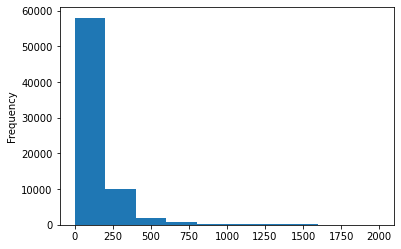

In [6]:
np.exp(train.log_price).plot(kind='hist');

## Split Data

In [7]:
y = train.price_category
X = train.drop(columns=['log_price', 'price_category','price_range', 'id'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((57406, 28), (57406,))

## Baseline

In [8]:
# Will use ROC-AUC or F1 Score for multiclass classification
# Watch this space

## Build Model

Select transformer strategy according to datatype  
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#use-columntransformer-by-selecting-column-by-data-types

In [9]:
# Pipeline

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude=["object","category"])),
    ('cat', categorical_transformer, selector(dtype_include=["object","category"]))
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier()),
])


In [10]:
set_config(display='diagram')
# Fit model to training data
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000225E713B220>),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000225F8E39B50>)])),
                ('classifier', RandomForestClassifier())])

## Metrics

In [11]:
print('Training Accuracy: ', clf.score(X_train, y_train))
print('Validation Accuracy: ', clf.score(X_val, y_val))

Training Accuracy:  0.996045709507717
Validation Accuracy:  0.3141025641025641


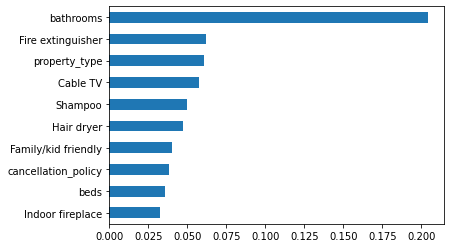

In [12]:
# Feature Importances
importances = clf.named_steps['classifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

## Tune Model

## Results

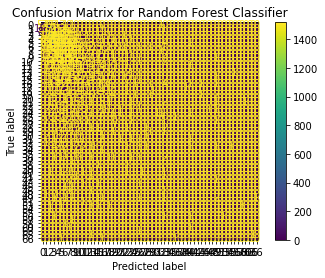

In [15]:
# Confusion Matrix
plot_confusion_matrix(
    estimator=clf,
    X=X_val,
    y_true=y_val,
    values_format='.0f',
)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

In [14]:
print(classification_report(
    y_true=y_val,
    y_pred=clf.predict(X_val)
))

              precision    recall  f1-score   support

           0       0.72      0.37      0.49       155
           1       0.51      0.64      0.57      2368
           2       0.39      0.44      0.42      2907
           3       0.26      0.30      0.28      2372
           4       0.20      0.17      0.18      1391
           5       0.22      0.26      0.24      1528
           6       0.18      0.16      0.17       973
           7       0.10      0.05      0.06       389
           8       0.11      0.09      0.10       471
           9       0.10      0.07      0.08       312
          10       0.08      0.04      0.05       290
          11       0.18      0.08      0.11       219
          12       0.03      0.01      0.02        81
          13       0.07      0.04      0.05       157
          14       0.14      0.02      0.03        52
          15       0.05      0.03      0.04        86
          16       0.13      0.08      0.10       133
          17       0.00    